## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
import sqlite3
import pandas as pd
import requests
from bs4 import BeautifulSoup

I imported in a dataset provided by IMDB's interface. Scraping the data from their website turned out to be unnecessary.

This database is still missing the cost to make movie and the profit. We found a database containing the production costs, worldwide and domestic gross income. This information is not given to us in a file unfortunately like the previous dataset was, so we will have to employ some datascraping to pull this data off the website. We are grabbing our data from https://www.the-numbers.com/movie/budgets/all
I defined 2 functions to ease the load since I need to run a separate iteration of this script in order to catch the first page due to it having a unique url. 

In [85]:
'''Takes in the URL as an argument, and returns the chart that the movies are in.'''
def html_parse(url):
    html_page = requests.get(url, timeout=5)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    chart = soup.find(id = 'page_filling_chart')
    movie_container = chart.findAll('tr') #grabs all movie entries on the page and puts into a list
    return movie_container

In [86]:
'''Takes in the row containing the movie title, profits, release date, and costs and returns a list of those.'''
def movie_extract(data_container):
        release_date = data_container[1].text #release date
        movie_name = data_container[2].text #name of movie
        prod_budget = data_container[3].get_text(strip=True) #production budget
        gross_dom = data_container[4].get_text(strip=True) #gross domestic 
        gross_world = data_container[5].get_text(strip=True) #gross worldwide
        #we want to strip all of the newline junk off of the text.
        
        return [release_date, movie_name, prod_budget, gross_dom, gross_world]

This is the initial run of the function due to the URL being unique for the very first page.

In [87]:
df = pd.DataFrame(columns = ['Release_Date', 'Movie_Name', 'Production_Budget', 'Gross_Domestic', 'Gross_Worldwide'])
url = "https://www.the-numbers.com/movie/budgets/all"
movie_container = html_parse(url)

#for loop here to iterate through the list of movies in movie_container
for u in range(1,101):
    data_container = movie_container[u].findAll('td')

    data_series = movie_extract(data_container)
    
    a_series = pd.Series(data_series, index = df.columns)
    df = df.append(a_series, ignore_index=True)

Iterates through all the pages utilizing URL hacking to find all of the pages.

In [88]:
for i in range(2,61): #change 4 to 61 for all
    url = "https://www.the-numbers.com/movie/budgets/all/{}01".format(i)
    movie_container = html_parse(url)

    #for loop here to iterate through the list of movies in movie_container
    for u in range(1,101): 
        if i == 60 and u == 44:
            break
        data_container = movie_container[u].findAll('td') #the tag we want to look through

        data_series = movie_extract(data_container)
        
        a_series = pd.Series(data_series, index = df.columns)
        df = df.append(a_series, ignore_index=True)


In [90]:
df.to_csv('zippedData/movieMoney.csv') #saving it to a CSV so I don't have to scrape everytime I want to look at the data

In [4]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
0,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,797,800,564"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,063,875","$1,045,663,875"
2,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,396,099,202"
3,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,065,478,084"
4,"Apr 25, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,359,754"
...,...,...,...,...,...
5938,Unknown,Red 11,"$7,000",$0,$0
5939,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5940,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5941,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


Putting in the datascrubbing + merging that was done by Simran around here I guess

1) Genre of movie affects profit
2) Number of reviews and profit
3) How does the number of movies created by a studio affect the average profit
4) What does the international market look like

Starting to look at and scrub the data. The first step is going to be converting the datatypes into a usable form. 

In [2]:
df = pd.read_csv('zippedData/movieMoney.csv', index_col=0)

In [3]:
df.dtypes

Release_Date         object
Movie_Name           object
Production_Budget    object
Gross_Domestic       object
Gross_Worldwide      object
dtype: object

In [4]:
df['Movie_Name'] = df['Movie_Name'].astype('string')

df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')

df['Production_Budget'] = df['Production_Budget'].str.replace('$', '')
df['Production_Budget'] = df['Production_Budget'].str.replace(',', '')
df['Production_Budget'] = df['Production_Budget'].astype(int)

df['Gross_Domestic'] = df['Gross_Domestic'].str.replace('$', '')
df['Gross_Domestic'] = df['Gross_Domestic'].str.replace(',', '')
df['Gross_Domestic'] = df['Gross_Domestic'].astype(int)

df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace('$', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].str.replace(',', '')
df['Gross_Worldwide'] = df['Gross_Worldwide'].astype('int64')

df.sort_values('Release_Date', inplace=True, ascending=False) #sort by release date, most recent on top
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


The second step is to remove the films from the dataframe that haven't happened yet. The next step is to count the number of films that have no budget or not profit to see if they can be removed from the dataset without any problems.

Here we are removing films based on time. We've decided that we're only going to look at recent movies, films created in 1980 and on, films that haven't come out yet, and also removing any films that came out this year as well, due to Coronavirus dramatically changing what the movie industry looks like. Movies will likely be back to "normal" by the time that we would finish with filming and editing a movie so we'll be able to use traditional data.

Alongside that, we'll be looking for any duplicates.

In [5]:
print(df[df.duplicated()]) #looking for any duplicated rows

Empty DataFrame
Columns: [Release_Date, Movie_Name, Production_Budget, Gross_Domestic, Gross_Worldwide]
Index: []


In [6]:
df.head()

,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide
1502,2022-12-16,Heaven and Hell,40000000,0,0
602,2021-01-15,355,75000000,0,0
108,2021-01-01,Moonfall,150000000,0,0
133,2020-12-23,Top Gun: Maverick,140000000,0,0
20,2020-11-12,No Time to Die,250000000,0,0


There doesn't seem to be any duplicated rows in our movie money dataframe.

In [7]:
df_filtered = df[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31')] 
print(df_filtered.head(), df_filtered.tail())

     Release_Date         Movie_Name  Production_Budget  Gross_Domestic  \
3640   2019-12-31         The Grudge           10000000        21216148   
2404   2019-12-27      The Gentlemen           22000000        36296854   
1293   2019-12-25       Little Women           42000000       108095955   
305    2019-12-25  Spies in Disguise          100000000        66757013   
287    2019-12-25               1917          100000000       159227644   

      Gross_Worldwide  
3640         49503265  
2404        111800189  
1293        209065465  
305         166083937  
287         358403321        Release_Date          Movie_Name  Production_Budget  Gross_Domestic  \
5332   1980-02-01             The Fog            1100000        21445318   
5680   1980-01-01              Maniac             350000        10000000   
4727   1980-01-01        Terror Train            3500000         8000000   
1713   1980-01-01  Lion of the Desert           35000000         1500000   
4166   1980-01-01     Dre

We're filtered down our money dataset to only contain the films that we are planning on looking at by date.

# Splice in the merging of the money dataset and the rating dataset here

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Our final dataset containing the movie budget information. 

In [3]:
df = pd.read_csv('Final_Data/Final_Movie_Budget.csv', index_col=0)
df.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Movie_Name,Production_Budget,Gross_Domestic,Gross_Worldwide,_merge,Gross_Foreign_Only
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142,9.3,2259481.0,60.0,60.0,"Sep 23, 1994",The Shawshank Redemption,25000000.0,28241469.0,2.841706e+07,both,175591.0
1,NaN,2008.0,The Dark Knight,tt0468569,152,9.0,2225006.0,59.0,59.0,"Jul 11, 2008",The Dark Knight,185000000.0,533720947.0,1.000743e+09,both,467021804.0
2,WB,2010.0,Inception,tt1375666,148,8.8,1982266.0,52.0,52.0,2010-07-16,NaN,160000000.0,292576195.0,8.355246e+08,left_only,535700000.0
3,NaN,1999.0,Fight Club,tt0137523,139,8.8,1794853.0,NaN,NaN,"Oct 15, 1999",Fight Club,65000000.0,37030102.0,1.008345e+08,both,63804388.0
4,NaN,1994.0,Pulp Fiction,tt0110912,154,8.9,1767823.0,51.0,51.0,"Sep 10, 1994",Pulp Fiction,8000000.0,107928762.0,2.129119e+08,both,104983148.0


We're creating the profit column here, adjusting for inflation for the year it came out to today's currency (2020)

In [4]:
df['Gross_Worldwide'] = df['Gross_Worldwide'] * (2020 - df['year'])*1.0322
df['Gross_Domestic'] = df['Gross_Domestic']* (2020- df['year'])*1.0322
df['Production_Budget'] = df['Production_Budget'] * (2020- df['year'])*1.0322
df['Gross_Foreign_Only'] = df['Gross_Foreign_Only'] * (2020- df['year'])*1.0322
df['Profit'] = (df['Gross_Worldwide'] - df['Production_Budget']) #create the profit column

In [5]:
df.dtypes

studio                 object
year                  float64
Movie_title            object
tconst                 object
runtimeMinutes         object
averageRating         float64
numVotes              float64
region                float64
language              float64
Release_Date           object
Movie_Name             object
Production_Budget     float64
Gross_Domestic        float64
Gross_Worldwide       float64
_merge                 object
Gross_Foreign_Only    float64
Profit                float64
dtype: object

In [6]:
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce') #converting runtime into a number from a string
df.drop(['_merge', 'Movie_Name'], axis = 1, inplace=True) #columns we don't need anymore

In [8]:
print('Movie_title', '\n', df['Movie_title'].isna().sum())
print('tconst', '\n', df['tconst'].isna().sum())
df.dropna(subset=['tconst'], inplace=True)
print('Movie_title', '\n', df['Movie_title'].isna().sum())
print('tconst', '\n', df['tconst'].isna().sum())

Movie_title 
 0
tconst 
 0
Movie_title 
 0
tconst 
 0


Making sure that our dateset only contains the movies that fall within the timeframe we're looking at. Should've been done earlier, but if anything was missed it'll be caught here. We will also create another column for the season the movie was released in. Winter: Jan-Mar, Spring: Apr-Jun, Summer: July-Sept, Fall: Oct-Dec

In [9]:
season_dict = {1.0 : 'Winter', 2.0 : 'Winter' , 3.0 : 'Spring',
              4.0 : 'Spring', 5.0 : 'Spring', 6.0 : 'Summer',
              7.0 : 'Summer', 8.0 : 'Summer', 9.0 : 'Fall',
              10.0 : 'Fall', 11.0 : 'Fall', 12.0 : 'Winter',
              'NaN' : 'NaN'}
#may want to adjust the months back 1 so December isn't a fall month. 
df['Release_Date'] = pd.to_datetime(df.Release_Date, errors='coerce') #convert into datetimes
df.sort_values(by='Release_Date') #sort by release date

df['Month'] = df['Release_Date'].dt.month
df['Season'] = df['Release_Date'].dt.month.map(season_dict)
df['year'] = df['Release_Date'].dt.year
df.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Production_Budget,Gross_Domestic,Gross_Worldwide,Gross_Foreign_Only,Profit,Month,Season
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142.0,9.3,2259481.0,60.0,60.0,1994-09-23,6.709300e+08,7.579220e+08,7.626343e+08,4.712371e+06,9.170432e+07,9.0,Fall
1,NaN,2008.0,The Dark Knight,tt0468569,152.0,9.0,2225006.0,59.0,59.0,2008-07-11,2.291484e+09,6.610881e+09,1.239560e+10,5.784719e+09,1.010412e+10,7.0,Summer
2,WB,2010.0,Inception,tt1375666,148.0,8.8,1982266.0,52.0,52.0,2010-07-16,1.651520e+09,3.019971e+09,8.624285e+09,5.529495e+09,6.972765e+09,7.0,Summer
3,NaN,1999.0,Fight Club,tt0137523,139.0,8.8,1794853.0,NaN,NaN,1999-10-15,1.408953e+09,8.026719e+08,2.185709e+09,1.383037e+09,7.767556e+08,10.0,Fall
4,NaN,1994.0,Pulp Fiction,tt0110912,154.0,8.9,1767823.0,51.0,51.0,1994-09-10,2.146976e+08,2.896506e+09,5.713960e+09,2.817454e+09,5.499262e+09,9.0,Fall


In [10]:
df_filter = df.loc[(df['Release_Date'] < '2020-01-01') & (df['Release_Date'] > '1979-12-31') &
                  (df['runtimeMinutes'] > 60)] #select the right dates
df_filter.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Production_Budget,Gross_Domestic,Gross_Worldwide,Gross_Foreign_Only,Profit,Month,Season
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142.0,9.3,2259481.0,60.0,60.0,1994-09-23,6.709300e+08,7.579220e+08,7.626343e+08,4.712371e+06,9.170432e+07,9.0,Fall
1,NaN,2008.0,The Dark Knight,tt0468569,152.0,9.0,2225006.0,59.0,59.0,2008-07-11,2.291484e+09,6.610881e+09,1.239560e+10,5.784719e+09,1.010412e+10,7.0,Summer
2,WB,2010.0,Inception,tt1375666,148.0,8.8,1982266.0,52.0,52.0,2010-07-16,1.651520e+09,3.019971e+09,8.624285e+09,5.529495e+09,6.972765e+09,7.0,Summer
3,NaN,1999.0,Fight Club,tt0137523,139.0,8.8,1794853.0,NaN,NaN,1999-10-15,1.408953e+09,8.026719e+08,2.185709e+09,1.383037e+09,7.767556e+08,10.0,Fall
4,NaN,1994.0,Pulp Fiction,tt0110912,154.0,8.9,1767823.0,51.0,51.0,1994-09-10,2.146976e+08,2.896506e+09,5.713960e+09,2.817454e+09,5.499262e+09,9.0,Fall


In [11]:
genre_raw_df = pd.read_csv('zippedData/title.basics.tsv', low_memory=False, sep='\t')

drop anything not a "movie."

In [12]:
genre_raw_df = genre_raw_df[genre_raw_df['titleType'] =='movie']
genre_raw_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,20,"Documentary,News,Sport"
332,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama"
499,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
571,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama"


We're merging the genre data into the dataset that contains the rest of our information, including votes, money, and release dates. 

In [13]:
df_filter = df_filter.merge(genre_raw_df[['tconst', 'genres']], how='inner', on='tconst')

In [14]:
df_filter['genres'] = df_filter['genres'].apply(lambda x: x.split(','))
genre_df_col = df_filter.columns.drop('genres')

For each movie, ensure that each of its genres is represented in the dataset. 

In [15]:
genre_df = df_filter['genres'].apply(pd.Series)\
    .merge(df_filter, right_index = True, left_index=True)\
    .drop(['genres'], axis=1)\
    .melt(id_vars=genre_df_col, value_name = 'genre')\
    .drop('variable', axis=1)\
    .dropna(subset=['genre'])
genre_order = genre_df['genre'].unique()

In [16]:
genre_df.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Production_Budget,Gross_Domestic,Gross_Worldwide,Gross_Foreign_Only,Profit,Month,Season,genre
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142.0,9.3,2259481.0,60.0,60.0,1994-09-23,6.709300e+08,7.579220e+08,7.626343e+08,4.712371e+06,9.170432e+07,9.0,Fall,Drama
1,NaN,2008.0,The Dark Knight,tt0468569,152.0,9.0,2225006.0,59.0,59.0,2008-07-11,2.291484e+09,6.610881e+09,1.239560e+10,5.784719e+09,1.010412e+10,7.0,Summer,Action
2,WB,2010.0,Inception,tt1375666,148.0,8.8,1982266.0,52.0,52.0,2010-07-16,1.651520e+09,3.019971e+09,8.624285e+09,5.529495e+09,6.972765e+09,7.0,Summer,Action
3,NaN,1999.0,Fight Club,tt0137523,139.0,8.8,1794853.0,NaN,NaN,1999-10-15,1.408953e+09,8.026719e+08,2.185709e+09,1.383037e+09,7.767556e+08,10.0,Fall,Drama
4,NaN,1994.0,Pulp Fiction,tt0110912,154.0,8.9,1767823.0,51.0,51.0,1994-09-10,2.146976e+08,2.896506e+09,5.713960e+09,2.817454e+09,5.499262e+09,9.0,Fall,Crime


# 1) What genres do best, and what is the best season for each genre?

(-8000000, 7000000000)

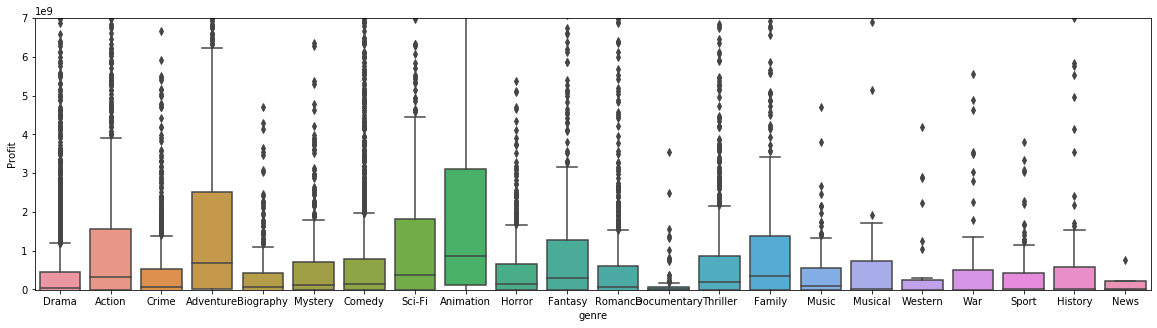

In [17]:
plt.figure(figsize=(20,5))
sns.boxplot(x='genre', y='Profit', data=genre_df,
            order=genre_order)
plt.ylim(-8000000,7000000000)

(-8000000, 7000000000)

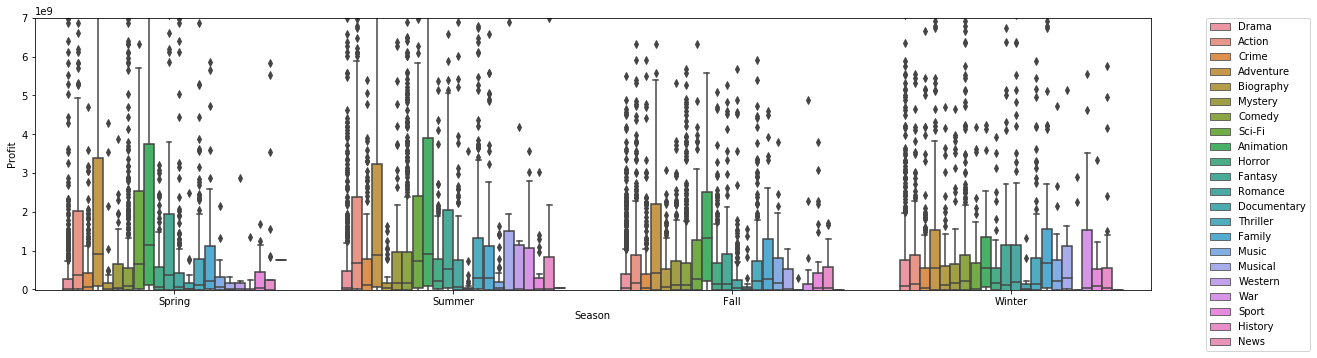

In [18]:
plt.figure(figsize=(20,5))
sns.boxplot(x='Season', y='Profit', hue='genre', data=genre_df,
           order=['Spring', 'Summer', 'Fall', 'Winter'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})
plt.ylim(-8000000,7000000000)
#idk depends on the number of genres really

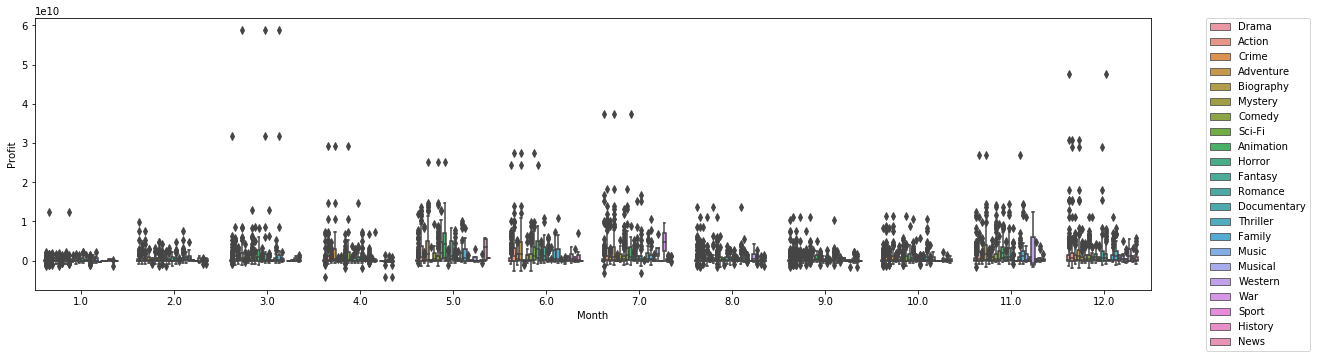

In [19]:
plt.figure(figsize=(20,5))
sns.boxplot(x='Month', y='Profit', hue='genre', data=genre_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})

(-800000000, 8000000000)

<Figure size 360x1440 with 0 Axes>

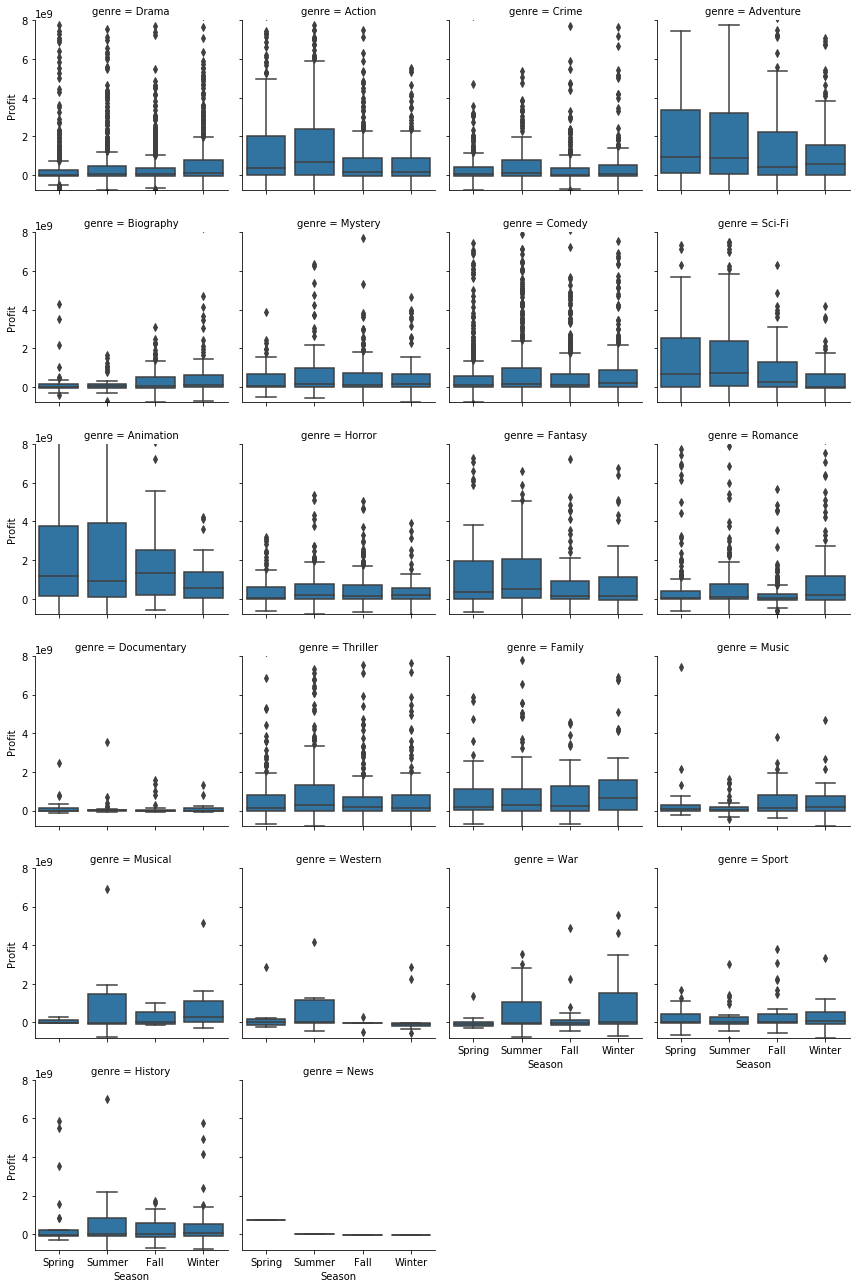

In [20]:
plt.figure(figsize=(5,20))
g = sns.FacetGrid(genre_df, col="genre", col_wrap=4, margin_titles=True)
g.map(sns.boxplot, "Season", "Profit", order=['Spring', 'Summer', 'Fall', 'Winter']);
plt.ylim(-800000000, 8000000000)

This shows us a little bit. Things like: news, history, sport, westerns, and documentaries don't really have much profit in them, and things like adventure, action, sci-fi, animation and comedies can do well. But lets break it down by month specifically, and see if there's anything hidden there.

(-800000000, 10000000000)

<Figure size 360x1440 with 0 Axes>

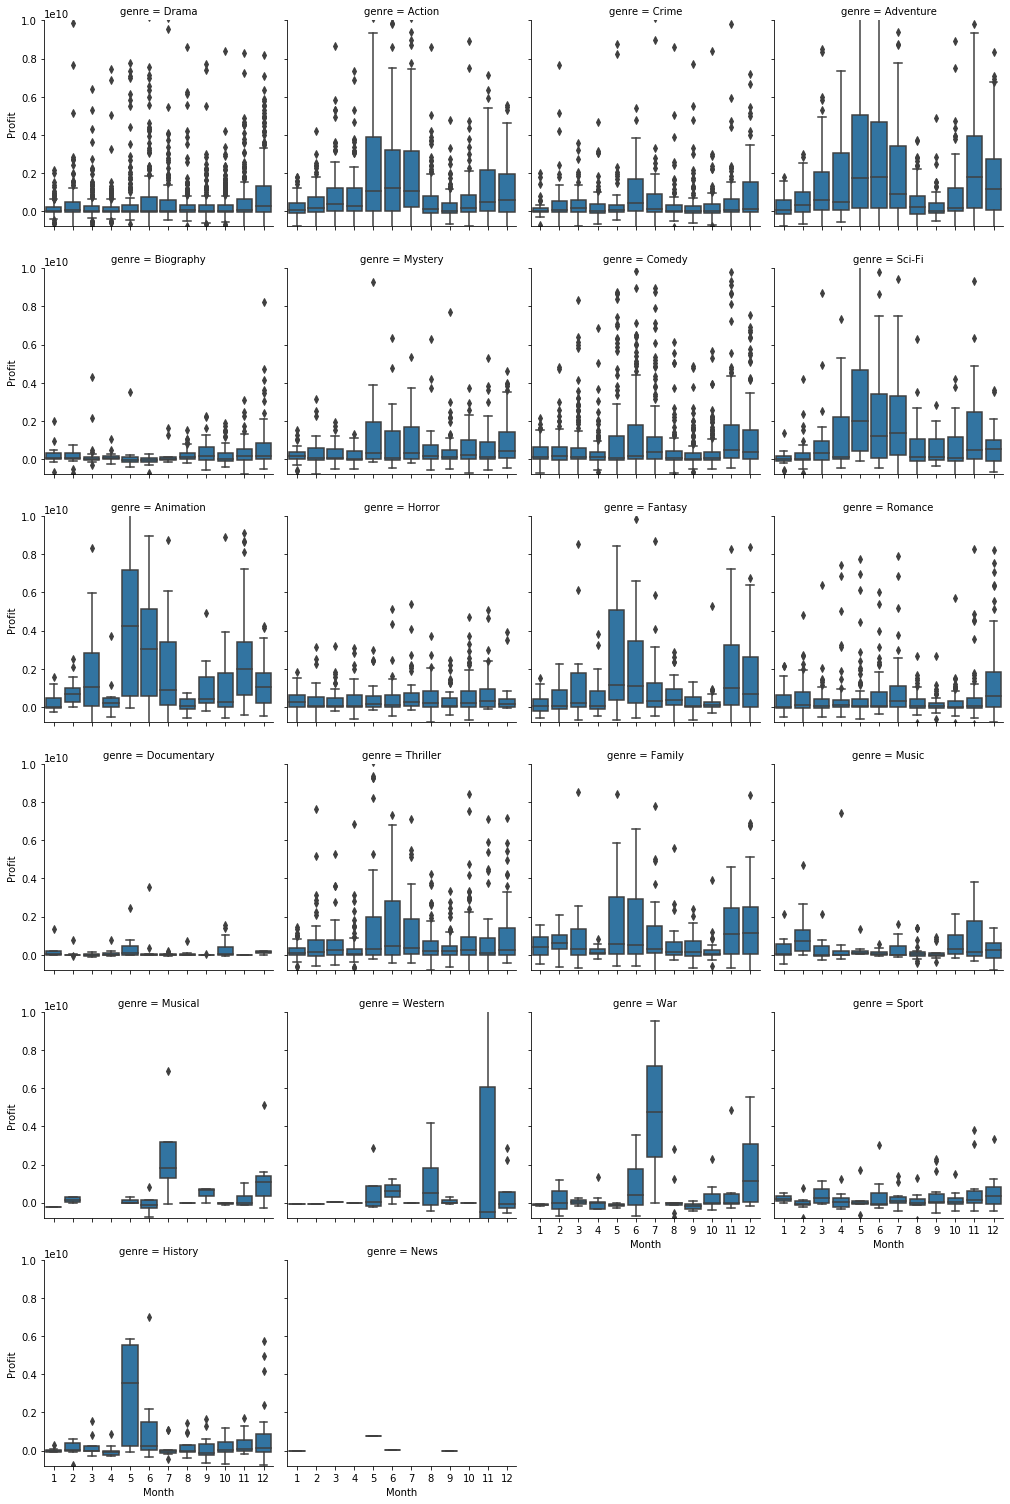

In [21]:
plt.figure(figsize=(5,20))
g = sns.FacetGrid(genre_df, col="genre", col_wrap=4, margin_titles=True, height=3.5)
g.map(sns.boxplot, "Month", "Profit", order=[1,2,3,4,5,6,7,8,9,10,11,12]);
plt.ylim(-800000000, 10000000000)

This breakdown shows us more of the same, however we do see two things stand out. War movies seem to do well in July and December, and history movies seem to do well in May. 

We've only been looking at profit, which is related to production costs. What we want to see next is what types of movies are cheaper to produce, as well as how much gross income those types of movies have in general. We'll do that by taking the median costs, profits, and gross incomes for each genre of movie.

In [22]:
genre_median_df = genre_df.groupby(['genre']).agg({
                            'Profit' : 'median',
                            'Production_Budget' : 'median',
                            'Gross_Domestic' : 'median',
                            'Gross_Worldwide' : 'median'})
genre_median_df = genre_median_df.reset_index()
genre_median_df.head()

,genre,Profit,Production_Budget,Gross_Domestic,Gross_Worldwide
0,Action,3.100255e+08,536744000.0,4.548291e+08,8.697296e+08
1,Adventure,6.950370e+08,701896000.0,6.707393e+08,1.384201e+09
2,Animation,8.713480e+08,655447000.0,6.998387e+08,1.620019e+09
3,Biography,5.820776e+07,185796000.0,1.350055e+08,2.312142e+08
4,Comedy,1.325265e+08,247728000.0,2.784890e+08,4.332862e+08


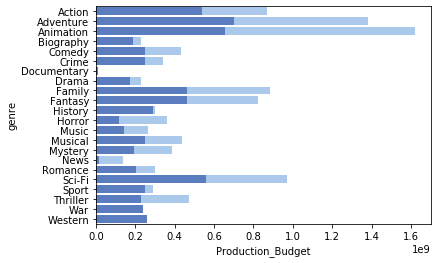

In [23]:
sns.set_color_codes("pastel")
sns.barplot(x="Gross_Worldwide", y="genre", data=genre_median_df,
            label="Profit", color="b")


sns.set_color_codes("muted")
sns.barplot(x="Production_Budget", y="genre", data=genre_median_df,
            label="Production Budget", color="b")

What we see here is that News films have the best cost to income ratio, where they're cheap to produce while having a reasonable chance for making a profit. However as we saw previously, they don't make a whole lot of money in general. The next best choice is going to be an Animation film. War movies, Westerns, History, Documentaries, and Biographies are less safe bets in general.  

# 2) How does the amount of money put into the film affect the profitability of it?

We are looking at if the number of votes is related to the amount of money that is made by the film.

In [24]:
df_prod_out = df_filter[(df_filter['numVotes'] > 250)]
df_prod_out.head()

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Production_Budget,Gross_Domestic,Gross_Worldwide,Gross_Foreign_Only,Profit,Month,Season,genres
0,NaN,1994.0,The Shawshank Redemption,tt0111161,142.0,9.3,2259481.0,60.0,60.0,1994-09-23,6.709300e+08,7.579220e+08,7.626343e+08,4.712371e+06,9.170432e+07,9.0,Fall,[Drama]
1,NaN,2008.0,The Dark Knight,tt0468569,152.0,9.0,2225006.0,59.0,59.0,2008-07-11,2.291484e+09,6.610881e+09,1.239560e+10,5.784719e+09,1.010412e+10,7.0,Summer,"[Action, Crime, Drama]"
2,WB,2010.0,Inception,tt1375666,148.0,8.8,1982266.0,52.0,52.0,2010-07-16,1.651520e+09,3.019971e+09,8.624285e+09,5.529495e+09,6.972765e+09,7.0,Summer,"[Action, Adventure, Sci-Fi]"
3,NaN,1999.0,Fight Club,tt0137523,139.0,8.8,1794853.0,NaN,NaN,1999-10-15,1.408953e+09,8.026719e+08,2.185709e+09,1.383037e+09,7.767556e+08,10.0,Fall,[Drama]
4,NaN,1994.0,Pulp Fiction,tt0110912,154.0,8.9,1767823.0,51.0,51.0,1994-09-10,2.146976e+08,2.896506e+09,5.713960e+09,2.817454e+09,5.499262e+09,9.0,Fall,"[Crime, Drama]"


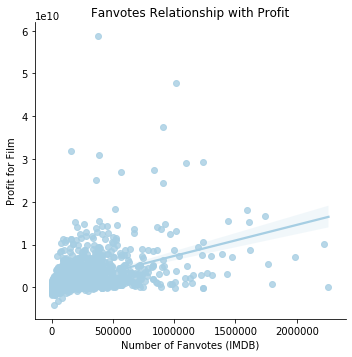

In [25]:
sns.set_palette(sns.color_palette('Paired'))
lmplot1 = sns.lmplot(x='numVotes', y='Profit', data=df_prod_out)
lmplot1.set(xlabel = "Number of Fanvotes (IMDB)", ylabel='Profit for Film', title='Fanvotes Relationship with Profit')

Here we are going to be looking at if there is a relationship between how much money is spent on a film and if more money spent on the film results in more votes, which we've assumed to mean more views.

In [26]:
print('95% of movies have less than :', df_prod_out['numVotes'].quantile(.95), 'votes')
print( 'the top 5 voted movies\n', df_prod_out.nlargest(5,'numVotes')['numVotes'])

print('95% of movies have less than :', df_prod_out['Profit'].quantile(.95), 'profit')
print( 'the top 5 profitable movies\n', df_prod_out.nlargest(5,'Profit')['Profit'])
print('5% of movies have less than :', df_prod_out['Profit'].quantile(.05), 'profit')
print( 'the bottom 5 profitable movies\n', df_prod_out.nsmallest(5,'Profit')['Profit'])

print('95% of movies have less than :', df_prod_out['Production_Budget'].quantile(.95), 'production budget')
print( 'the top 5 production value movies\n', df_prod_out.nlargest(5,'Production_Budget')['Production_Budget'])

95% of movies have less than : 419569.5999999995 votes
the top 5 voted movies
 0    2259481.0
1    2225006.0
2    1982266.0
3    1794853.0
4    1767823.0
Name: numVotes, dtype: float64
95% of movies have less than : 4693489416.162557 profit
the top 5 profitable movies
 312     5.879296e+10
32      4.767607e+10
43      3.749005e+10
1021    3.175934e+10
295     3.084834e+10
Name: Profit, dtype: float64
5% of movies have less than : -341272898.3195999 profit
the bottom 5 profitable movies
 3366   -4.216866e+09
2393   -3.224003e+09
1763   -2.510036e+09
3121   -1.896221e+09
4222   -1.855967e+09
Name: Profit, dtype: float64
95% of movies have less than : 1703130000.0 production budget
the top 5 production value movies
 295     1.858889e+10
312     1.424436e+10
294     9.401278e+09
199     9.021428e+09
1763    7.266688e+09
Name: Production_Budget, dtype: float64


Most movies have less than 500,000 votes, with a very small amount having more than 1.5 million. We don't want to include those in our number of votes plots because those movies are exceptional.

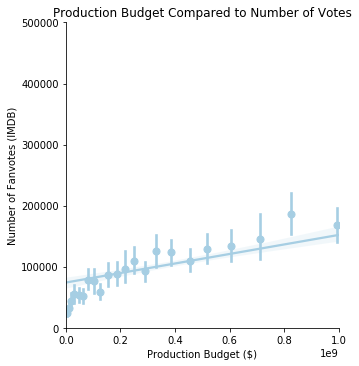

In [27]:
lmplot2 = sns.lmplot(y='numVotes', x='Production_Budget',x_bins=25, data=df_prod_out)
lmplot2.set(xlabel = "Production Budget ($)", ylabel='Number of Fanvotes (IMDB)', 
            title='Production Budget Compared to Number of Votes',
           xlim=(0,1000000000), #limiting budget to 1billion dollars
           ylim=(0,500000)) #limiting the number of votes to 500000

There seems to be a relationship between the budget and the number of votes that that film receives. The more money spent on a film, the more votes that it will receive. 

And finally, looking at the relationship directly. Production value and profit. We're going to limit the budget to 1.7billion, the maximum profit to 4.5billion, and the minimum profit to -3.5 million.

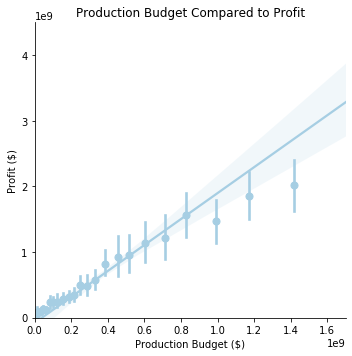

In [28]:
lmplot3 = sns.lmplot(y='Profit', x='Production_Budget', x_bins=25, data=df_prod_out)
lmplot3.set(xlabel = "Production Budget ($)", ylabel='Profit ($)', 
            title='Production Budget Compared to Profit',
               xlim=(0,1700000000), #limiting budget to 1.7billion
               ylim=(-3500000,4500000000)) #maximum profit being 4.5billion

It looks like there is a relationship between the profitability of a film and the amount of money spent on it. It looks pretty linear, but we stop seeing as much gains after spending 1 billion. 

Does the rating of the film affect its profitability?

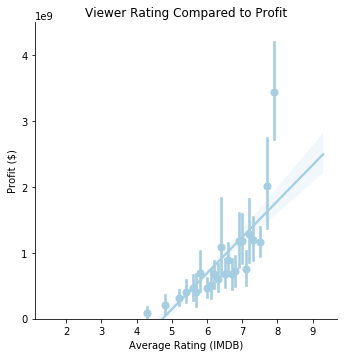

In [29]:
lmplot4 = sns.lmplot(y='Profit', x='averageRating', x_bins=25, data=df_prod_out)
lmplot4.set(xlabel = "Average Rating (IMDB)", ylabel='Profit ($)', 
            title='Viewer Rating Compared to Profit',
           ylim=(-3500000,4500000000))

Very well rated movies have more profit. Do well rated movies also have larger production budgets?

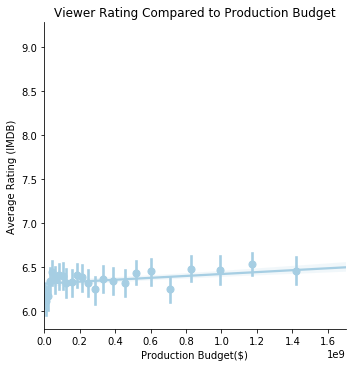

In [30]:
lmplot4 = sns.lmplot(y='averageRating', x='Production_Budget', x_bins=25, data=df_prod_out)
lmplot4.set(ylabel = "Average Rating (IMDB)", xlabel='Production Budget($)', 
            title='Viewer Rating Compared to Production Budget',
           xlim=(0,1700000000))

It doesn't appear to be too much of a relationship between production budgets leading towards higher ratings. There is a slight increase as the budget increases, but there is likely a different driving factor towards increasing the viewer rating. 

# 3) How does the number of movies created by a studio affect the average profit

In [31]:
df_filter.sort_values(by=['Release_Date', 'studio'])

,studio,year,Movie_title,tconst,runtimeMinutes,averageRating,numVotes,region,language,Release_Date,Production_Budget,Gross_Domestic,Gross_Worldwide,Gross_Foreign_Only,Profit,Month,Season,genres
2844,NaN,1980.0,Maniac,tt2103217,89.0,6.1,34321.0,17.0,17.0,1980-01-01,1.445080e+07,4.128800e+08,4.128800e+08,0.000000e+00,3.984292e+08,1.0,Winter,"[Horror, Thriller]"
2858,NaN,1980.0,Dressed to Kill,tt0080661,104.0,7.1,33579.0,31.0,31.0,1980-01-01,2.683720e+08,1.317046e+09,1.317046e+09,0.000000e+00,1.048674e+09,1.0,Winter,"[Mystery, Thriller]"
3638,NaN,1980.0,Lion of the Desert,tt0081059,173.0,8.4,13529.0,30.0,30.0,1980-01-01,1.445080e+09,6.193200e+07,6.193200e+07,0.000000e+00,-1.383148e+09,1.0,Winter,"[Biography, Drama, History]"
3875,NaN,1980.0,Terror Train,tt0081617,97.0,5.9,9410.0,31.0,31.0,1980-01-01,1.445080e+08,3.303040e+08,3.303040e+08,0.000000e+00,1.857960e+08,1.0,Winter,"[Horror, Mystery, Thriller]"
2145,NaN,1980.0,The Fog,tt0080749,89.0,6.8,61621.0,56.0,56.0,1980-02-01,4.541680e+07,8.854343e+08,8.854550e+08,2.072658e+04,8.400382e+08,2.0,Winter,"[Horror, Thriller]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,NaN,2019.0,Midway,tt6924650,138.0,6.7,50616.0,39.0,39.0,2019-11-07,1.032200e+08,5.867727e+07,1.289921e+08,7.031483e+07,2.577210e+07,11.0,Fall,"[Action, Adventure, Drama]"
4654,NaN,2019.0,The Islands,tt5304664,89.0,5.7,722.0,6.0,6.0,2019-12-06,3.715920e+06,0.000000e+00,0.000000e+00,0.000000e+00,-3.715920e+06,12.0,Winter,[Adventure]
3167,NaN,2019.0,Black Christmas,tt0454082,84.0,4.6,24291.0,25.0,25.0,2019-12-13,7.225400e+07,1.507179e+08,2.677558e+08,1.170379e+08,1.955018e+08,12.0,Winter,[Horror]
1351,NaN,2019.0,Little Women,tt3281548,135.0,7.9,113879.0,48.0,48.0,2019-12-25,1.127162e+09,2.900993e+09,5.610732e+09,2.709739e+09,4.483569e+09,12.0,Winter,"[Drama, Romance]"


Here we are going to group our films by what year they came out, and by what studio created them. We're looking at the number of films released by a studio that year, how much money it made, and alongside that, the costs to create it.

In [32]:
studio_df = df_filter.loc[df_filter['studio'] != 'NaN'].groupby(['year', 'studio']).agg({
                                                'Movie_title' : 'count', 
                                               'numVotes' : 'median',
                                               'Production_Budget' : 'median',
                                               'Gross_Domestic' : 'median',
                                               'Gross_Worldwide' : 'median',
                                               'Profit' : 'median'})
studio_df.head()

Movie_title  numVotes  Production_Budget  Gross_Domestic  \
year   studio                                                             
1984.0 Sony              1  168119.0         82576000.0    9.373982e+08   
1986.0 FD                1   28233.0        289016000.0    1.651520e+07   
       Uni.              1  152257.0        129025000.0    8.000640e+07   
1999.0 Par.              1   64096.0         18579600.0    3.206405e+05   
2001.0 DR                1    3027.0          2477280.0    2.753001e+05   

               Gross_Worldwide        Profit  
year   studio                                 
1984.0 Sony       9.373982e+08  8.548222e+08  
1986.0 FD         1.651520e+07 -2.725008e+08  
       Uni.       1.213157e+08 -7.709311e+06  
1999.0 Par.       6.303005e+05 -1.794930e+07  
2001.0 DR         2.753001e+05 -2.201980e+06

[Text(0, 0.5, 'Median Profit ($)'),
 Text(0.5, 0, 'Number of Movies in a Year by a Studio'),
 Text(0.5, 1.0, 'Median Profit per Year By Number of Releases')]

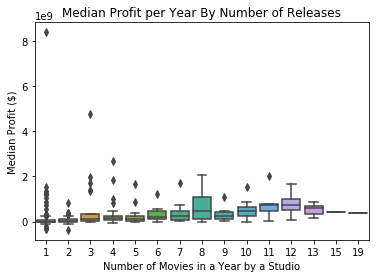

In [33]:
boxplot1 = sns.boxplot(x='Movie_title', y='Profit', data=studio_df)
boxplot1.set(xlabel = "Number of Movies in a Year by a Studio", ylabel='Median Profit ($)', title='Median Profit per Year By Number of Releases')

[Text(0, 0.5, 'Median Fanvotes ($)'),
 Text(0.5, 0, 'Number of Movies in a Year by a Studio'),
 Text(0.5, 1.0, 'Median Fanvotes per Year By Number of Releases')]

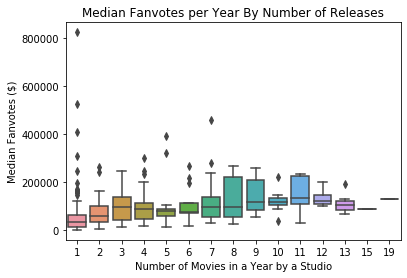

In [34]:
boxplot2 = sns.boxplot(x='Movie_title', y='numVotes', data=studio_df)
boxplot2.set(xlabel = "Number of Movies in a Year by a Studio", ylabel='Median Fanvotes ($)', title='Median Fanvotes per Year By Number of Releases')

Looks like the best amount of movies to release in a year around 10? 

# 4) What do international markets look like for movies now?

In [35]:
yearly_df = df_filter.groupby(['year']).agg({
                                            'Gross_Domestic' : 'mean',
                                               'Production_Budget' : 'mean',
                                               'Gross_Domestic' : 'mean',
                                               'Gross_Worldwide' : 'mean',
                                               'Profit' : 'mean'})
yearly_df = yearly_df.reset_index()
yearly_df.head()


,year,Gross_Domestic,Production_Budget,Gross_Worldwide,Profit
0,1980.0,1.156240e+09,5.550490e+08,1.194978e+09,6.399287e+08
1,1981.0,1.356772e+09,5.059844e+08,1.922017e+09,1.416033e+09
2,1982.0,1.386816e+09,5.098380e+08,1.962848e+09,1.453010e+09
3,1983.0,1.107085e+09,5.064580e+08,1.802440e+09,1.295982e+09
4,1984.0,2.018603e+09,5.096392e+08,2.493688e+09,1.984048e+09


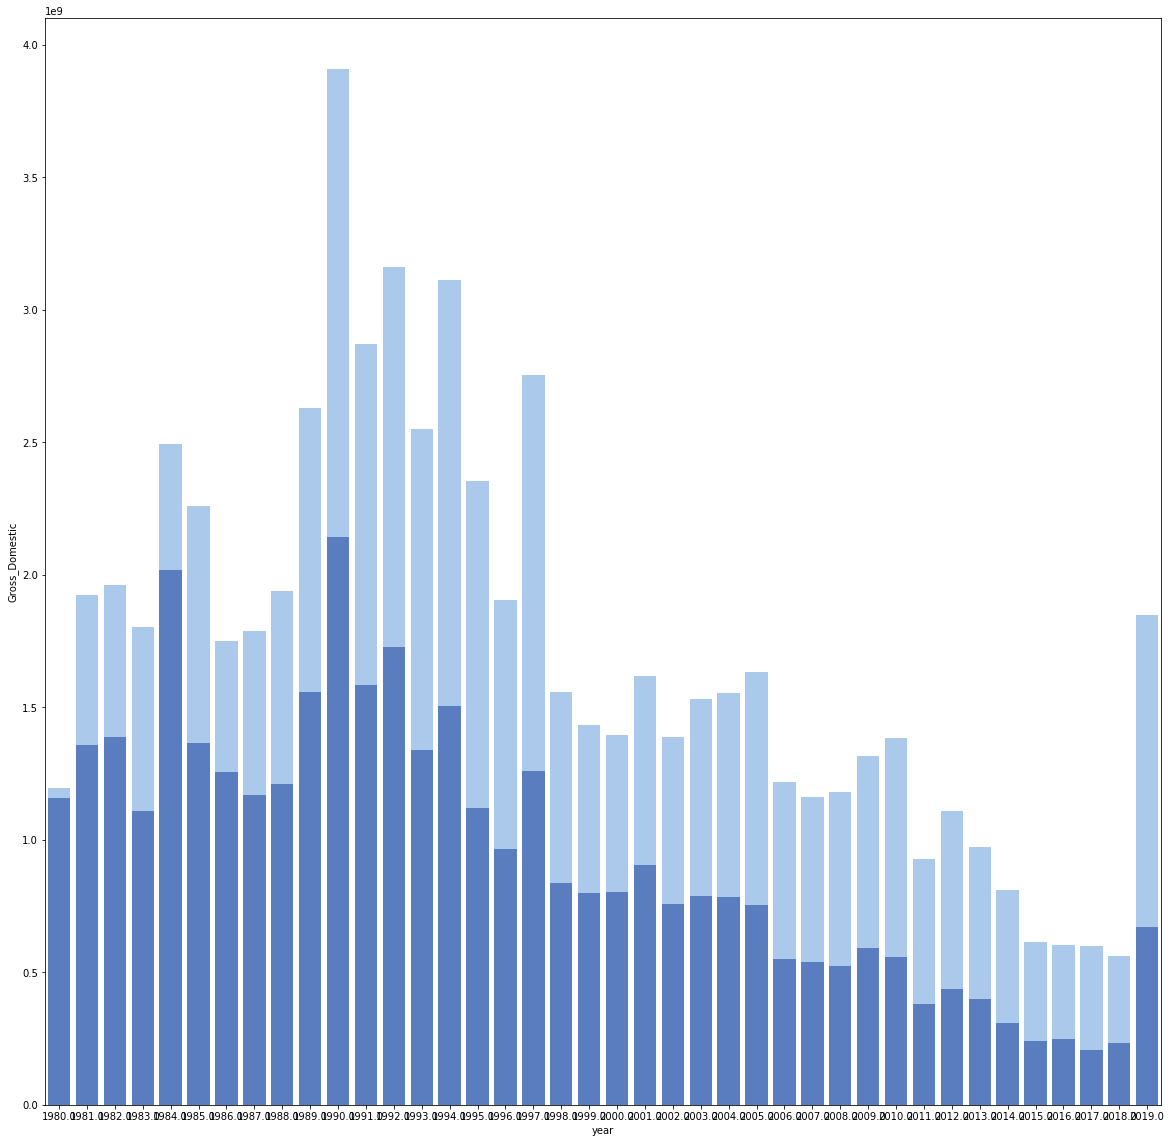

In [36]:
plt.figure(figsize=(20,20))
sns.set_color_codes("pastel")
sns.barplot(y="Gross_Worldwide", x="year", data=yearly_df,
            label="Gross Worldwide", color="b")


sns.set_color_codes("muted")
sns.barplot(y="Gross_Domestic", x="year", data=yearly_df,
            label="Gross Domestic", color="b")

Honestly looks like my dataset is missing something. Movies aren't less profitable now than they were 20 years ago.

So we want more than 7 movies in a year. What kinds of movies are we going to release and when are we going to release them, and how much should we spend on each?
1)Animation
2)Action
3)Adventure
4)Family
5)Fantasy
6)War
7)News/Documentary -There's no real good timeline to release this one. I only recommend it because its so cheap to create. 
8)Sci-Fi